# Fake News Detection : Fake Or Real

In [1]:
# Importation des bibliothèques nécessaires
import os
import pickle
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
train_data = pd.read_csv("data/fake_or_real_news.csv")

# Remplacer "FAKE" par 0 et "REAL" par 1 dans la colonne "label"
train_data['label'] = train_data['label'].map({'FAKE': 0, 'REAL': 1})

# Diviser les données en caractéristiques (X) et labels (y)
X = train_data["text"]  # Le texte des articles
y = train_data["label"]  # Les labels (0 ou 1)

### Retrieve, format and describe the data statistically

In [6]:
# Afficher les premières lignes du DataFrame
print(train_data.head())

   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


In [8]:
# Statistiques descriptives de base
def describe_data(df):
    """Affiche les statistiques descriptives et des informations sur les données."""
    # Afficher les informations générales sur le DataFrame
    print("\nInfo générale sur les données :")
    print(df.info())
    
    # Afficher les statistiques descriptives des données textuelles
    print("\nStatistiques descriptives des données :")
    print(df.describe())

    # Vérifier les valeurs manquantes
    missing_data = df.isnull().sum()
    print("\nValeurs manquantes :")
    print(missing_data)

    # Répartition des classes (fake vs real)
    class_counts = df['label'].value_counts()
    print("\nRépartition des classes :")
    print(class_counts)

    # Distribution de la longueur des articles (en nombre de mots)
    df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))  # Calcul de la longueur en mots
    print("\nStatistiques sur la longueur des articles :")
    print(df['text_length'].describe())
    
    # Visualisation de la distribution de la longueur des articles
    plt.figure(figsize=(10,6))
    sns.histplot(df['text_length'], bins=50, kde=True)
    plt.title('Distribution de la longueur des articles')
    plt.xlabel('Nombre de mots')
    plt.ylabel('Fréquence')
    plt.show()


Info générale sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None

Statistiques descriptives des données :
         Unnamed: 0
count   6335.000000
mean    5280.415627
std     3038.503953
min        2.000000
25%     2674.500000
50%     5271.000000
75%     7901.000000
max    10557.000000

Valeurs manquantes :
Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

Répartition des classes :
label
REAL    3171
FAKE    3164
Name: count, dtype: int64

Statistiques sur la longueur des articles :
count     6335.000000
mean       776.300710
std        854.333358
min          0.000000
25%        289.000000
50% 

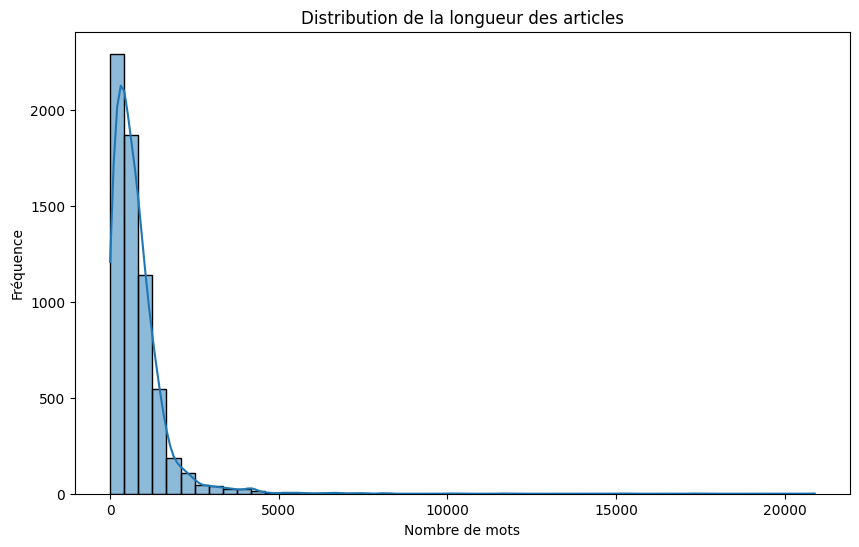

In [9]:
# Exécution de la fonction de description
describe_data(train_data)

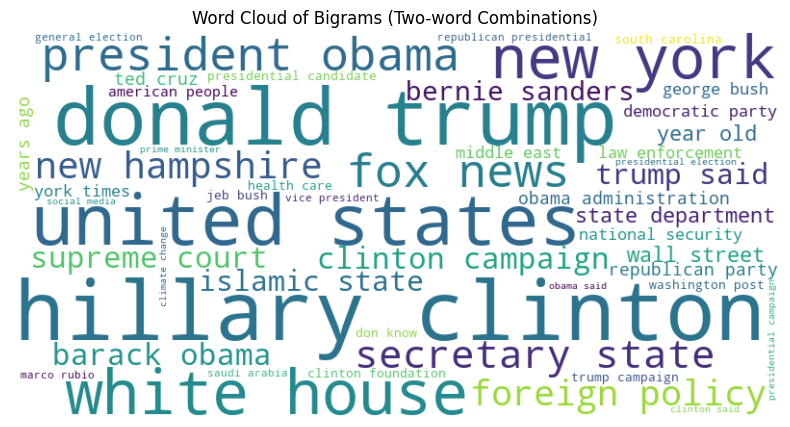

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Extraire des bigrammes
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=50)
bigrams = vectorizer.fit_transform(train_data['text'])

# Créer un word cloud pour les bigrammes
bigram_freq = dict(zip(vectorizer.get_feature_names_out(), bigrams.sum(axis=0).A1))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Bigrams (Two-word Combinations)")
plt.show()

Ici, pour faire un Word Cloud cohérent, on enlève les stop_words et on lemmatize à la racine.

In [18]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pandas as pd
from tqdm import tqdm

# Charger le modèle spaCy en désactivant les composants inutiles
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Fonction de prétraitement en batch avec nlp.pipe()
def preprocess_batch(texts, batch_size=50, max_length=2000):
    processed_texts = []
    for doc in nlp.pipe((text[:max_length].lower() for text in texts), batch_size=batch_size):
        processed_texts.append(" ".join(token.lemma_ for token in doc if token.text not in STOP_WORDS and token.text not in string.punctuation))
    return processed_texts

# Charger les données (exemple avec un DataFrame)
# train_data = pd.read_csv("chemin_vers_fichier.csv")

# Afficher une barre de progression avec tqdm
tqdm.pandas()

# Appliquer le prétraitement sur la colonne 'text'
train_data["processed_text"] = preprocess_batch(train_data["text"].tolist())

# Vérifier les résultats
print(train_data[["text", "processed_text"]].head())

                                                text  \
0  Daniel Greenfield, a Shillman Journalism Fello...   
1  Google Pinterest Digg Linkedin Reddit Stumbleu...   
2  U.S. Secretary of State John F. Kerry said Mon...   
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...   
4  It's primary day in New York and front-runners...   

                                      processed_text  
0  daniel greenfield shillman journalism fellow f...  
1  google pinterest digg linkedin reddit stumbleu...  
2  u.s secretary state john f. kerry say monday s...  
3  — kaydee king @kaydeeking november 9 2016 less...  
4  primary day new york runner hillary clinton do...  


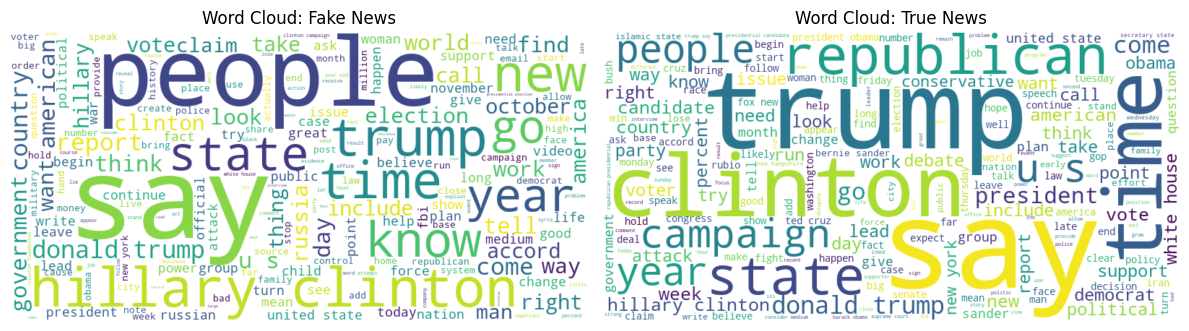

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Fusionner les textes traités pour chaque classe
fake_news_text = " ".join(train_data[train_data["label"] == 0]["processed_text"])
true_news_text = " ".join(train_data[train_data["label"] == 1]["processed_text"])

# Générer les word clouds
fake_news_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(fake_news_text)
true_news_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(true_news_text)

# Affichage des word clouds
plt.figure(figsize=(12, 6))

# Word Cloud des fausses nouvelles
plt.subplot(1, 2, 1)
plt.imshow(fake_news_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Fake News")

# Word Cloud des vraies nouvelles
plt.subplot(1, 2, 2)
plt.imshow(true_news_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: True News")

plt.tight_layout()
plt.show()

### Experiments with the proposed model

#### Bag of Words & TF-IDF

##### Prétraitement

In [3]:
def preprocess_full(text):
    """Prétraitement complet pour les modèles Bag of Words et TF-IDF (avec lemmatisation)."""
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des URLs et handles Twitter
    text = re.sub(r"http\S+|www\S+|@\S+", "", text)
    
    # Suppression de la ponctuation et des espaces supplémentaires
    text = re.sub(r"[^\w\s]", "", text)
    
    # Suppression des espaces blancs supplémentaires
    text = re.sub(r"\s+", " ", text).strip()
    
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text

In [4]:
def extract_bow_features(X_train, X_test):
    """Extrait les caractéristiques Bag of Words des jeux de données après prétraitement complet."""
    
    # Appliquer le prétraitement complet sur les textes
    X_train_cleaned = [preprocess_full(text) for text in X_train]
    X_test_cleaned = [preprocess_full(text) for text in X_test]
    
    # Initialisation du CountVectorizer
    vectorizer = CountVectorizer(stop_words='english', max_features=5000)
    
    # Transformation des données en matrices BoW
    X_train_bow = vectorizer.fit_transform(X_train_cleaned)
    X_test_bow = vectorizer.transform(X_test_cleaned)
    
    return X_train_bow, X_test_bow

In [5]:
def extract_tfidf_features(X_train, X_test):
    """Extrait les caractéristiques TF-IDF des jeux de données après prétraitement complet."""
    
    # Appliquer le prétraitement complet sur les textes
    X_train_cleaned = [preprocess_full(text) for text in X_train]
    X_test_cleaned = [preprocess_full(text) for text in X_test]
    
    # Initialisation du TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    
    # Transformation des données en matrices TF-IDF
    X_train_tfidf = vectorizer.fit_transform(X_train_cleaned)
    X_test_tfidf = vectorizer.transform(X_test_cleaned)
    
    return X_train_tfidf, X_test_tfidf

In [6]:
# Diviser les données en ensemble d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Appliquer le prétraitement 
X_train_BoW, X_test_BoW = extract_bow_features(X_train, X_test)
X_train_tfidf, X_test_tfidf = extract_tfidf_features(X_train, X_test)

##### Modèles et évaluation

In [ ]:
def train_with_kfold(X, y, model_type="svm", k=5):
    """Entraîne un modèle avec une validation croisée stratifiée K-Fold et sauvegarde le modèle.""" 
    # Initialisation du modèle en fonction du type
    if model_type == "svm":
        model = SVC(kernel="linear")
    elif model_type == "random_forest":
        model = RandomForestClassifier()
    elif model_type == "logistic_regression":
        model = LogisticRegression()
    elif model_type == "gradient_boosting":
        model = GradientBoostingClassifier()
    elif model_type == "adaboost":
        model = AdaBoostClassifier()
    elif model_type == "neural_network":
        model = MLPClassifier()

    # Initialisation du Stratified K-Fold
    y = np.array(y)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Liste pour stocker les scores de chaque fold
    scores = []
    
    # K-Fold Cross Validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Entraîner le modèle sur chaque fold
        model.fit(X_train, y_train)
        
        # Calculer le score (accuracy ici)
        score = model.score(X_test, y_test)
        scores.append(score)
    
    # Afficher les scores moyens et les scores par fold
    print(f"Scores pour chaque fold: {scores}")
    print(f"Score moyen : {np.mean(scores)}")

    # Création du dossier
    os.makedirs("models_tfidf_FoR", exist_ok=True)

    # Sauvegarde du modèle
    model_filename = f"models_tfidf_FoR/{model_type}_tf_idf_FoR.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)

    return model, np.mean(scores)

In [ ]:
model_ab, mean_scores_ab = train_with_kfold(X_train_tfidf, y_train, model_type="adaboost", k=5)
#2min 0.8687837208985361
# model_ab, mean_scores_ab = train_with_kfold(X_train_BoW, y_train, model_type="adaboost", k=5)
#1min 0.8658235833571849

Scores pour chaque fold: [0.8678500986193294, 0.878698224852071, 0.863905325443787, 0.8667324777887463, 0.8667324777887463]
Score moyen : 0.8687837208985361


In [ ]:
model_gb = train_with_kfold(X_train_tfidf, y_train, model_type="gradient_boosting", k=5)
#3min 0.886346333950556
# model_gb = train_with_kfold(X_train_BoW, y_train, model_type="gradient_boosting", k=5)
#1min 0.8829903561394182

Scores pour chaque fold: [0.888560157790927, 0.8856015779092702, 0.8816568047337278, 0.8933859822309971, 0.8825271470878578]
Score moyen : 0.886346333950556


In [ ]:
model_lr = train_with_kfold(X_train_tfidf, y_train, model_type="logistic_regression", k=5)
#1s 0.9123904040374539
# model_lr = train_with_kfold(X_train_BoW, y_train, model_type="logistic_regression", k=5)
#1s 0.9062736691258217

Scores pour chaque fold: [0.9023668639053254, 0.9191321499013807, 0.9211045364891519, 0.9091806515301086, 0.910167818361303]
Score moyen : 0.9123904040374539


In [ ]:
model_nn = train_with_kfold(X_train_tfidf, y_train, model_type="neural_network", k=5)
#3min 0.9183097055828471
# model_nn = train_with_kfold(X_train_BoW, y_train, model_type="neural_network", k=5)
#2min  0.9078513836885771

Scores pour chaque fold: [0.9102564102564102, 0.9240631163708086, 0.9270216962524654, 0.9131293188548865, 0.9170779861796644]
Score moyen : 0.9183097055828471


In [ ]:
model_rf = train_with_kfold(X_train_tfidf, y_train, model_type="random_forest", k=5)
#30s 0.9080486223473543
# model_rf = train_with_kfold(X_train_BoW, y_train, model_type="random_forest", k=5)
#30s 0.9060762357595831

Scores pour chaque fold: [0.9063116370808678, 0.9142011834319527, 0.9132149901380671, 0.9022704837117473, 0.9042448173741362]
Score moyen : 0.9080486223473543


In [ ]:
model_svm = train_with_kfold(X_train_tfidf, y_train, model_type="svm", k=5)
#1min 0.9242295912506254
# model_svm = train_with_kfold(X_train_BoW, y_train, model_type="svm", k=5)
#1min 0.8612867047903876

Scores pour chaque fold: [0.9151873767258383, 0.9339250493096647, 0.928007889546351, 0.9210266535044422, 0.9230009871668312]
Score moyen : 0.9242295912506254


In [7]:
# Charger et évaluer le modèle
def evaluate_model(X_test, y_test, model_path):
    """Évalue un modèle chargé depuis un fichier."""
    try:
        # Charger le modèle depuis le fichier pickle
        with open(model_path, "rb") as f:
            model = pickle.load(f)
    except FileNotFoundError:
        print(f"Erreur : fichier {model_path} introuvable.")
        return

    # Prédiction avec le modèle chargé
    y_pred = model.predict(X_test)

    # Afficher les résultats d'évaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [13]:
evaluate_model(X_test_BoW, y_test, "models_BoW_FoR/random_forest_BoW_FoR.pkl")

Accuracy: 0.9123914759273876
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       628
           1       0.91      0.92      0.91       639

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267

Confusion Matrix:
 [[568  60]
 [ 51 588]]


In [19]:
evaluate_model(X_test_tfidf, y_test, "models_tfidf_FoR/logistic_regression_tf_idf_FoR.pkl")

Accuracy: 0.9084451460142068
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       628
           1       0.92      0.90      0.91       639

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267

Confusion Matrix:
 [[577  51]
 [ 65 574]]


#### Word2Vec & BERT & Linguistic Cues

##### Prétraitement

In [ ]:
def preprocess_light(text):
    """Prétraitement léger pour les modèles Word2Vec, BERT et Linguistic Cues (sans lemmatisation)."""
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des URLs et handles Twitter
    text = re.sub(r"http\S+|www\S+|@\S+", "", text)
    
    # Suppression des espaces blancs supplémentaires
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

In [22]:
import gensim.downloader as api
from gensim.models import KeyedVectors
import numpy as np

# Charger le modèle Word2Vec (évite de le télécharger à chaque exécution)
try:
    word2vec_model = KeyedVectors.load("word2vec-google-news-300.kv")  # Si déjà téléchargé
except FileNotFoundError:
    word2vec_model = api.load("word2vec-google-news-300")
    word2vec_model.save("word2vec-google-news-300.kv")  # Sauvegarde pour éviter le re-téléchargement

print(f"Word2Vec loaded! Vocab size: {len(word2vec_model.index_to_key)}")

Word2Vec loaded! Vocab size: 3000000


In [23]:
def extract_word2vec_features(X_train, X_test):
    """Extrait les caractéristiques Word2Vec des jeux de données après prétraitement léger."""
    
    def text_to_vec(text):
        """Convertit un texte en un vecteur moyen des embeddings de ses mots."""
        words = text.split()
        vecs = np.array([word2vec_model[word] for word in words if word in word2vec_model])
        return np.mean(vecs, axis=0) if len(vecs) > 0 else np.zeros(word2vec_model.vector_size)
    
    # Appliquer le prétraitement léger et vectoriser en une seule ligne
    X_train_cleaned = [preprocess_light(text) for text in X_train]
    X_test_cleaned = [preprocess_light(text) for text in X_test]
    
    X_train_word2vec = np.array([text_to_vec(text) for text in X_train_cleaned])
    X_test_word2vec = np.array([text_to_vec(text) for text in X_test_cleaned])
    
    return X_train_word2vec, X_test_word2vec

In [24]:
from transformers import DistilBertModel, DistilBertTokenizer
import torch

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [25]:
def extract_bert_features(X_train, X_test, batch_size=32):
    """Extrait les caractéristiques BERT en batch pour améliorer la vitesse."""
    
    def text_to_bert_vec(texts):
        """Convertir une liste de textes en vecteurs BERT (par batch)."""
        inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).numpy()

    # Appliquer le prétraitement léger et transformer en batchs
    X_train_cleaned = [preprocess_light(text) for text in X_train]
    X_test_cleaned = [preprocess_light(text) for text in X_test]

    # Traiter en batchs pour accélérer
    X_train_bert = np.vstack([text_to_bert_vec(X_train_cleaned[i:i+batch_size]) for i in range(0, len(X_train_cleaned), batch_size)])
    X_test_bert = np.vstack([text_to_bert_vec(X_test_cleaned[i:i+batch_size]) for i in range(0, len(X_test_cleaned), batch_size)])
    
    return X_train_bert, X_test_bert

In [4]:
def extract_linguistic_cues(X_train, X_test):
    import re
    import numpy as np
    import pandas as pd
    import spacy

    # Charger le modèle spaCy anglais
    nlp = spacy.load("en_core_web_sm")

    def count_words(doc):
        return len([token for token in doc if token.is_alpha])

    def count_syllables(text):
        vowels = "aeiouyAEIOUY"
        return sum([sum(1 for char in word if char in vowels) for word in text.split()])

    def count_sentences(doc):
        return len(list(doc.sents))

    def count_long_words(doc, threshold=6):
        return sum(1 for token in doc if len(token.text) > threshold and token.is_alpha)

    def count_all_caps(doc):
        return sum(1 for token in doc if token.text.isupper())

    def count_unique_words(doc):
        return len(set(token.text.lower() for token in doc if token.is_alpha))

    def count_personal_pronouns(doc):
        pronouns = {'i', 'we', 'she', 'he', 'him', 'me', 'us'}
        return sum(1 for token in doc if token.text.lower() in pronouns)

    def count_articles(doc):
        articles = {'a', 'an', 'the'}
        return sum(1 for token in doc if token.text.lower() in articles)

    def count_pos_tags(doc, pos_tags):
        return sum(1 for token in doc if token.tag_ in pos_tags)

    def count_punctuation(text, p):
        return text.count(p)

    def compute_features(texts):
        features = []
        docs = list(nlp.pipe(texts))
        for doc, text in zip(docs, texts):
            wc = count_words(doc)
            sc = count_sentences(doc)
            data = {
                'word_count': wc,
                'syllables_count': count_syllables(text),
                'sentence_count': sc,
                'words_per_sentence': wc / max(sc, 1),
                'long_words_count': count_long_words(doc),
                'all_caps_count': count_all_caps(doc),
                'unique_words_count': count_unique_words(doc),
                'personal_pronouns%': count_personal_pronouns(doc) / max(wc, 1),
                'articles%': count_articles(doc) / max(wc, 1),
                'prepositions%': count_pos_tags(doc, {'IN'}) / max(wc, 1),
                'auxiliary_verbs%': count_pos_tags(doc, {'VB', 'VBP', 'VBG'}) / max(wc, 1),
                'common_adverbs%': count_pos_tags(doc, {'RB', 'RBR', 'RBS'}) / max(wc, 1),
                'conjunctions%': count_pos_tags(doc, {'CC'}) / max(wc, 1),
                'negations%': count_pos_tags(doc, {'RB'}) / max(wc, 1),
                'common_verbs%': count_pos_tags(doc, {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}) / max(wc, 1),
                'common_adjectives%': count_pos_tags(doc, {'JJ', 'JJR', 'JJS'}) / max(wc, 1),
                'punctuation_count': sum(count_punctuation(text, p) for p in ['.', ',', ':', ';', '!', '?', '-', '(', ')']),
                'full_stop_count': count_punctuation(text, '.'),
                'commas_count': count_punctuation(text, ','),
                'colons_count': count_punctuation(text, ':'),
                'semi_colons_count': count_punctuation(text, ';'),
                'question_marks_count': count_punctuation(text, '?'),
                'exclamation_marks_count': count_punctuation(text, '!'),
                'dashes_count': count_punctuation(text, '-'),
                'apostrophe_count': count_punctuation(text, "'"),
                'brackets_count': count_punctuation(text, '(') + count_punctuation(text, ')')
            }
            features.append(data)
        return pd.DataFrame(features)

    return compute_features(X_train), compute_features(X_test)

In [5]:
# Diviser les données en ensemble d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Appliquer le prétraitement 
# X_train_W2V, X_test_W2V = extract_word2vec_features(X_train, X_test)
# X_train_Bert, X_test_Bert = extract_bert_features(X_train, X_test)
X_train_LC, X_test_LC = extract_linguistic_cues(X_train, X_test)

In [6]:
import pickle

# # Sauvegarde des features dans des fichiers
with open("X_train_LC.pkl", "wb") as f:
    pickle.dump(X_train_LC, f)

with open("X_test_LC.pkl", "wb") as f:
    pickle.dump(X_test_LC, f)

##### Modèles et évaluation

In [ ]:
def train_with_kfold(X, y, model_type="svm", k=5):
    # Initialisation du modèle en fonction du type
    if model_type == "svm":
        model = SVC(kernel="linear")
    elif model_type == "random_forest":
        model = RandomForestClassifier()
    elif model_type == "logistic_regression":
        model = LogisticRegression()
    elif model_type == "gradient_boosting":
        model = GradientBoostingClassifier()
    elif model_type == "adaboost":
        model = AdaBoostClassifier()
    elif model_type == "neural_network":
        model = MLPClassifier()

    # Initialisation du Stratified K-Fold
    y = np.array(y)  # S'assurer que y est un tableau numpy
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Liste pour stocker les scores de chaque fold
    scores = []

    # K-Fold Cross Validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # ✅ Utilisation de .iloc
        y_train, y_test = y[train_index], y[test_index]  # ✅ y peut rester tel quel

        # Entraîner le modèle sur chaque fold
        model.fit(X_train, y_train)

        # Calculer le score (accuracy ici)
        score = model.score(X_test, y_test)
        scores.append(score)

    # Afficher les scores moyens et les scores par fold
    print(f"Scores pour chaque fold: {scores}")
    print(f"Score moyen : {np.mean(scores)}")

    # Création du dossier
    os.makedirs("models_LC_FoR", exist_ok=True)

    # Sauvegarde du modèle
    model_filename = f"models_LC_FoR/{model_type}_LC_FoR.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)

    return model, np.mean(scores)

In [13]:
# model_ab, mean_scores_ab = train_with_kfold(X_train_W2V, y_train, model_type="adaboost", k=5)
#2min 0.8312968879906386
model_ab, mean_scores_ab = train_with_kfold(X_train_LC, y_train, model_type="adaboost", k=5)
#5min 0.8431391905231983

Scores pour chaque fold: [0.7731755424063116, 0.7919132149901381, 0.8175542406311637, 0.7936821322803553, 0.7956564659427443]
Score moyen : 0.7943963192501426


In [14]:
# model_gb, mean_scores_gb = train_with_kfold(X_train_W2V, y_train, model_type="gradient_boosting", k=5)
#5min 0.8638515861843373
model_gb, mean_scores_gb = train_with_kfold(X_train_LC, y_train, model_type="gradient_boosting", k=5)
#13min 0.871156231320253

Scores pour chaque fold: [0.8037475345167653, 0.8136094674556213, 0.8244575936883629, 0.8292201382033564, 0.8173741362290227]
Score moyen : 0.8176817740186257


In [12]:
# model_lr, mean_scores_lr = train_with_kfold(X_train_W2V, y_train, model_type="logistic_regression", k=5)
#1s 0.8303083582072116
model_lr, mean_scores_lr = train_with_kfold(X_train_LC, y_train, model_type="logistic_regression", k=5)
#1s 0.8950300920382173

c:\Users\marcd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\marcd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Scores pour chaque fold: [0.7919132149901381, 0.7712031558185405, 0.7761341222879684, 0.7808489634748272, 0.7798617966436328]
Score moyen : 0.7799922506430214


c:\Users\marcd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# model_nn, mean_scores_nn = train_with_kfold(X_train_W2V, y_train, model_type="neural_network", k=5)
#2min 0.8975936104799344
model_nn, mean_scores_nn = train_with_kfold(X_train_LC, y_train, model_type="neural_network", k=5)
#1min 0.8964129044317366

Scores pour chaque fold: [0.7080867850098619, 0.7080867850098619, 0.7958579881656804, 0.7808489634748272, 0.6979269496544916]
Score moyen : 0.7381614942629446


In [16]:
# model_rf, mean_scores_rf = train_with_kfold(X_train_W2V, y_train, model_type="random_forest", k=5)
#1min 0.8553697397345358
model_rf, mean_scores_rf = train_with_kfold(X_train_LC, y_train, model_type="random_forest", k=5)
#1min 0.859708600812709

Scores pour chaque fold: [0.8185404339250493, 0.8244575936883629, 0.8412228796844181, 0.8381046396841066, 0.8361303060217177]
Score moyen : 0.8316911706007308


In [17]:
# model_svm, mean_scores_svm = train_with_kfold(X_train_W2V, y_train, model_type="svm", k=5)
#7s 0.8569466754674439
model_svm, mean_scores_svm = train_with_kfold(X_train_LC, y_train, model_type="svm", k=5)
#11s 0.8999628108748011

Scores pour chaque fold: [0.7909270216962525, 0.7692307692307693, 0.7682445759368837, 0.786771964461994, 0.7857847976307996]
Score moyen : 0.7801918257913398


In [18]:
# Charger et évaluer le modèle
def evaluate_model(X_test, y_test, model_path):
    """Évalue un modèle chargé depuis un fichier."""
    try:
        # Charger le modèle depuis le fichier pickle
        with open(model_path, "rb") as f:
            model = pickle.load(f)
    except FileNotFoundError:
        print(f"Erreur : fichier {model_path} introuvable.")
        return

    # Prédiction avec le modèle chargé
    y_pred = model.predict(X_test)

    # Afficher les résultats d'évaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [27]:
evaluate_model(X_test_LC, y_test, "models_LC_FoR/svm_LC_FoR.pkl")

Accuracy: 0.7805840568271507
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77       628
           1       0.77      0.80      0.79       639

    accuracy                           0.78      1267
   macro avg       0.78      0.78      0.78      1267
weighted avg       0.78      0.78      0.78      1267

Confusion Matrix:
 [[478 150]
 [128 511]]


In [39]:
evaluate_model(X_test_Bert, y_test, "models_Bert_FoR/adaboost_Bert_FoR.pkl")

Accuracy: 0.8587213891081295
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       628
           1       0.86      0.86      0.86       639

    accuracy                           0.86      1267
   macro avg       0.86      0.86      0.86      1267
weighted avg       0.86      0.86      0.86      1267

Confusion Matrix:
 [[538  90]
 [ 89 550]]


### Analysis of results and conclusion